In [17]:
%matplotlib inline

import ipyparallel

In [18]:
c = ipyparallel.Client(profile='env3')

In [21]:
v = c.direct_view()

In [22]:
c.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [23]:
r = v.execute('%cd ~/solid')

In [24]:
%%px --local
import sparsedm
import numpy as np
import matplotlib.pyplot as plt
import circuit
#import seaborn as sns

In [51]:
%%px --local

def repetition_code(t_gate=40, t_rest=1000, t_meas=300, t1=25000, t2=16000, ro_error=0.015, seed=0):    
    c = circuit.Circuit("Five-bit repetition code")

    qubit_names =  ["D1", "A1", "D2", "A2", "D3", "A3", "D4", "A4", "D5"]
    ancillas = [qb for qb in qubit_names if "A" in qb]
    data_qubits = [qb for qb in qubit_names if "D" in qb]

    for qb in qubit_names:
        c.add_qubit(qb, t1, t2)

    for a in ancillas:
        c.add_hadamard(a, time=0.5*t_gate)
    
    
    c.add_cphase("A1", "D1", time=1.5*t_gate)
    c.add_cphase("A2", "D2", time=1.5*t_gate)
    c.add_cphase("A3", "D3", time=1.5*t_gate)
    c.add_cphase("A4", "D4", time=1.5*t_gate)
    
    
    c.add_cphase("A1", "D2", time=3.5*t_gate)
    c.add_cphase("A2", "D3", time=3.5*t_gate)
    c.add_cphase("A3", "D4", time=3.5*t_gate)
    c.add_cphase("A4", "D5", time=3.5*t_gate)
    
    for a in ancillas:
        c.add_hadamard(a, time=4.5*t_gate)

    x=seed
    meass = []
    for a in ancillas:
        sampler = circuit.uniform_sampler(seed=x)
        m = circuit.Measurement(a, time=5*t_gate+0.5*t_meas, sampler=sampler)
        c.add_gate(m, time=5*t_gate+0.5*t_meas)
        meass.append(m)
        x+=1
    
    for d in data_qubits:
        c.add_rotate_y(d, angle=np.pi, time=5*t_gate+0.5*t_meas)


    c.add_waiting_gates(tmin=0, tmax=5*t_gate+t_meas+t_rest)
    c.order()

    return c, m

In [ ]:
%%px --local

import qec
import qec.circuit_characterization.error_model.unsymmetrised_decay as err_model
import qec.circuit_characterization.circuit_model.three_qbit_realistic_kraus as circuit_model
import qec.error_correction.correction_method.asym_de_rep as correction

tom_error = err_model.Error(T1=t1, ro=readout_error, t_rest=t_rest, Tphi=t2) 
tom_circuit = circuit_model.Circuit(tom_error, t_rest, t_gate, t_meas)
tom_decoder = correction.Correction(tom_circuit)

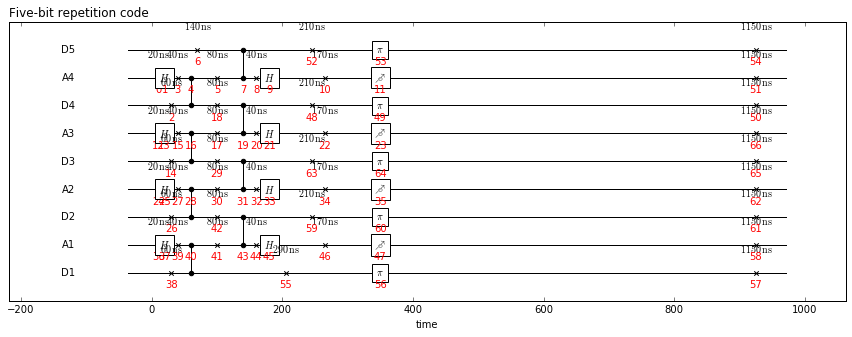

In [52]:
c, _ = repetition_code()
plt.figure(figsize=(15,5))
c.plot()

In [27]:

def run(seed):
    
    np.random.seed(seed)

    
    c, meas = repetition_code(seed=seed)
    
    qubit_names = c.get_qubit_names()
    sdm = sparsedm.SparseDM(qubit_names)

    no_steps = 20
    
    sdm.classical['A1'] = np.random.randint(2)
    sdm.classical['A2'] = np.random.randint(2)
    sdm.classical['A3'] = np.random.randint(2)
    sdm.classical['A4'] = np.random.randint(2)

    sdm.classical['D1'] = np.random.randint(2)
    sdm.classical['D2'] = sdm.classical['D1']
    sdm.classical['D3'] = sdm.classical['D1']
    sdm.classical['D4'] = sdm.classical['D1']
    sdm.classical['D5'] = sdm.classical['D1']

    tom_decoder.reset(initstate=[sdm.classical[b] for b in ['A1', 'A2', 'A3', 'A4']])

    init_state = sdm.classical['D1']
    
    fidelity_list = []
    
    for i in range(no_steps):
        c.apply_to(sdm)
        sdm.renormalize()
        
        syndrome = [m.measurements[-1] for m in meas]
        
        tom_decoder.

        actual_states = sdm.peak_multiple_measurements(['D1', 'D2', 'D3', 'D4', 'D5'])
               
        fidelity = 0.0
        for state, prob in actual_states:
            majority_vote = int(sum(state.values()) >= 3)
            if majority_vote == (init_state)%2:
                fidelity += prob

        fidelity_list.append(fidelity)
        
    return fidelity_list

In [28]:
%%time
r = v.map_sync(run, range(1000))

CPU times: user 2.1 s, sys: 7.44 s, total: 9.55 s
Wall time: 42min 21s


In [29]:
fi = np.array(r)

In [30]:
fi.shape

(10000, 20)

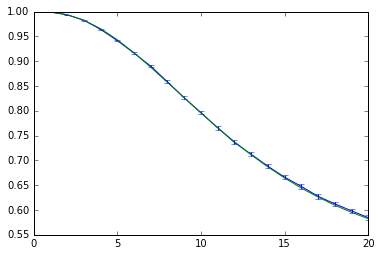

In [48]:
t_rest = 1000
t_gate = 40
t_meas = 300
t1 = 25000

p = np.exp(-(t_rest+5*t_gate+t_meas)/t1)


#plt.plot(range(1, 20+1), fi.mean(0), ".")
plt.errorbar(range(1, 20+1), fi.mean(0), yerr=fi.std(0)/100)

#plt.plot(range(1, 20+1), fi.mean(0), ".")

n = np.arange(1, 21)



plt.plot(range(1, 21), 
         [1-((1-p**n)**5 + 5*p**n*(1-p**n)**4 + 10*p**(2*n)*(1-p**n)**3)/2 for n in np.arange(1, 20+1)])